# Probability Estimation via Scoring


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.metrics import accuracy_score, brier_score_loss, r2_score

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

<div align="justify">

There are various methods in machine learning for inducing probabilistic predictors.
These are hypotheses $h$ that do not merely output point predictions $h(\vec{x}) \in \mathcal{Y}$, 
i.e., elements of the output space $\mathcal{Y}$, 
but probability estimates $p_h(\cdot \vert \vec{x}) =  p(\cdot \vert \vec{x}, h)$, 
i.e., complete probability distributions on $\mathcal{Y}$. 
In the case of classification, 
this means predicting a single (conditional) probability $p_h(y \vert \vec{x}) = p(y \vert \vec{x} , h)$ for each class $y \in \mathcal{Y}$, 
whereas in regression, $p( \cdot \vert \vec{x}, h)$ is a density function on $\mathbb{R}$. 
Such predictors can be learned in a discriminative way, 
i.e., in the form of a mapping $\vec{x} \mapsto p( \cdot \vert \vec{x})$, 
or in a generative way, which essentially means learning a joint distribution on $\mathcal{X} \times \mathcal{Y}$. 
Moreover, the approaches can be parametric (assuming specific parametric families of probability distributions) or non-parametric. 
Well-known examples include classical statistical methods such as logistic and linear regression, 
Bayesian approaches such as Bayesian networks and Gaussian processes (see [here](https://advueu963.github.io/PageTest/chapter-gaussianprocess/intro.html)), 
as well as various techniques in the realm of (deep) neural networks (cf. {doc}`chapter-deep_neuralnetwork/dnn`).  

</div>

<div align="justify">

Training probabilistic predictors is typically accomplished by minimizing suitable loss functions, 
i.e., loss functions that enforce "correct" (conditional) probabilities as predictions. 
In this regard, 
{doc}`proper_scoring_rules` ({cite:t}`gnei_sp05`) 
play an important role, 
including the log-loss as a well-known special case. 
Sometimes, however, estimates are also obtained in a very simple way, 
following basic frequentist techniques for probability estimation, 
like in Naïve Bayes or nearest neighbor classification. 

</div>

## 1. Example: Probabilistic Predictor with Logistic Regression

<div align="justify">

Logistic regression is a widely used supervised machine learning method for binary classification that provides probabilistic outputs. 
Below is an example using `scikit-learn`. Let us first make a synthetic binary classification dataset. 
Since the dataset has 20 features, 
it can be challenging to visualize all features at once. Instead, we use the first two features for a simple scatter plot.

</div>

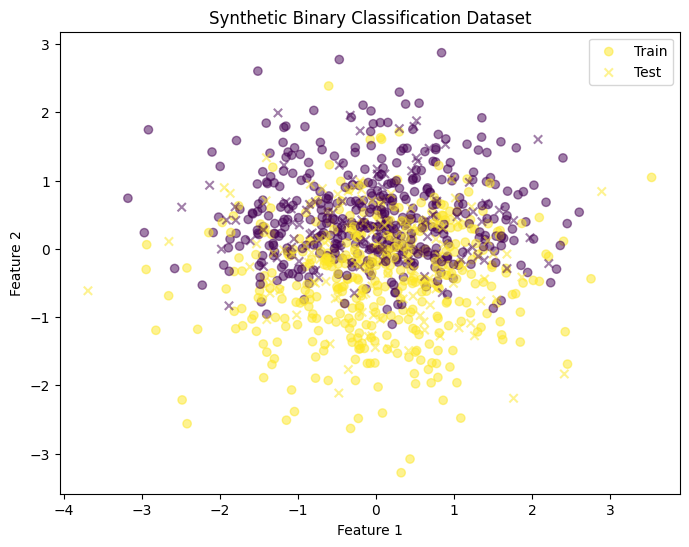

In [84]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

X_2d = X[:, :2] 
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', marker='o', alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='x', alpha=0.5, label='Test')
plt.title('Synthetic Binary Classification Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

<div align="justify">

Below we plot the decision boundary for a logistic regression model using the first two features as well.

</div>

/var/folders/3p/bdr8j4td0z9bjg8_ngvzj9600000gn/T/ipykernel_76839/2650500348.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='x', alpha=0.5, label='Test')


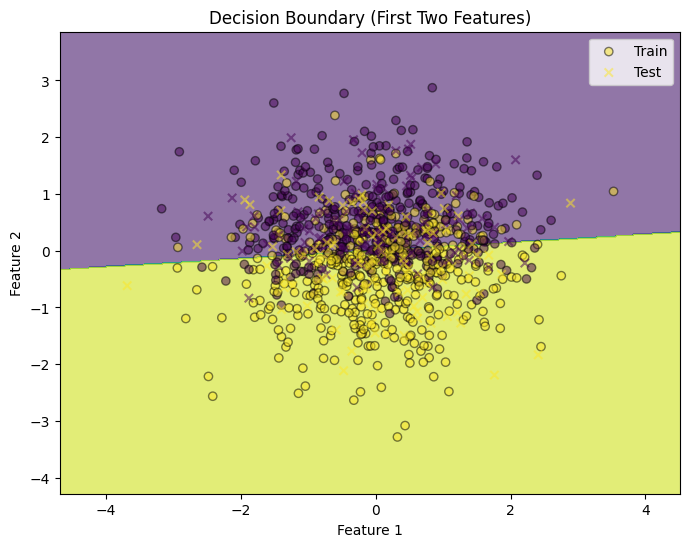

In [85]:
model = LogisticRegression()
model.fit(X_train, y_train)

h = .02
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', marker='o', alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='x', alpha=0.5, label='Test')
plt.title('Decision Boundary (First Two Features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [86]:
y_pred = model.predict(X_test)
p_pred = model.predict_proba(X_test)[:, 1]

loss = log_loss(y_test, p_pred)
accuracy = accuracy_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, p_pred)
log_score = -np.mean(np.log(p_pred[y_test == 1]))

print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Logarithmic Score: {log_score:.4f}")

Log Loss: 0.5899
Accuracy: 0.6850
Brier Score: 0.2039
Logarithmic Score: 0.6852


## 2. Example: Linear Regression

<div align="justify">

In statistics, linear regression is a statistical model used for predicting a continuous target variable. Let us also plot a synthetic regression dataset first.

</div>

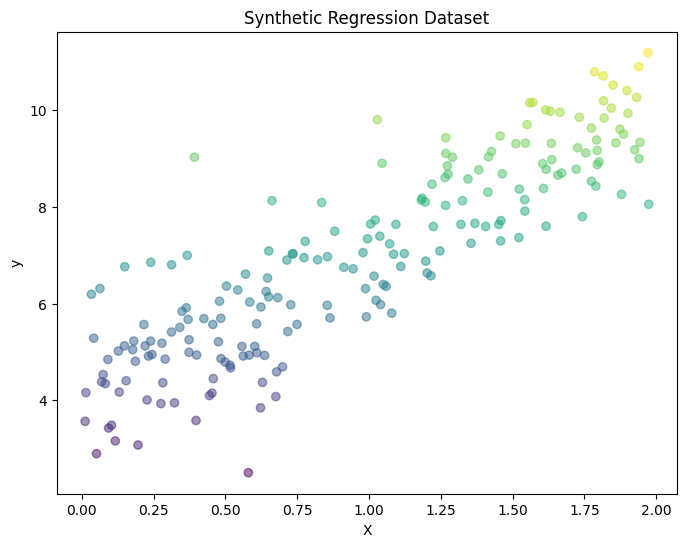

In [96]:
np.random.seed(42)
X = 2 * np.random.rand(200, 1)
y = 4 + 3 * X + np.random.randn(200, 1)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', alpha=0.5)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Regression Dataset")
plt.show()

<div align="justify">

Similarly, we train a linear regressor on this dataset and plot them.

</div>

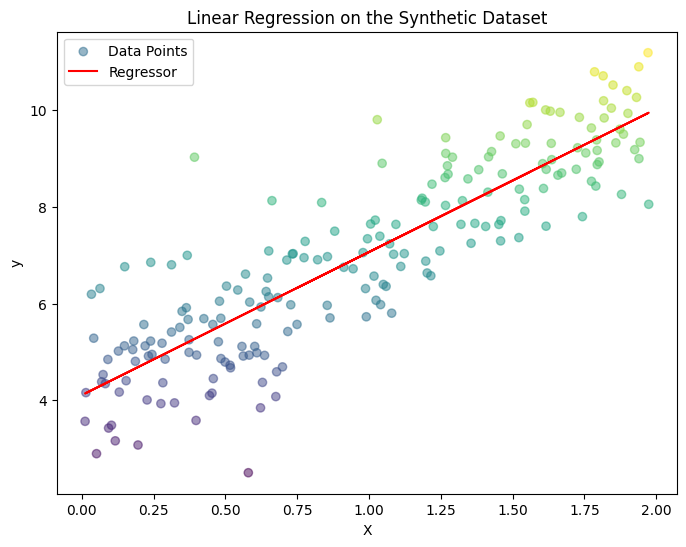

In [97]:
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
plt.plot(X, y_pred, c='red', label='Regressor')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression on the Synthetic Dataset")
plt.legend()
plt.show()

<div align="justify">

```{note}
We here calculate the Mean Squared Error (MSE), $R^2$, and Continuous Ranked Probability Score (CRPS) for this regression problem because Brier Score and Logarithmic Score are typically used for probabilistic classification models.
```

</div>

In [98]:
def crps(y_true, y_pred):
    residuals = y_true - y_pred
    y_std = np.std(residuals)
    crps_values = []
    
    for i in range(len(y_true)):
        mu = y_pred[i]
        sigma = y_std
        obs = y_true[i]
        term1 = np.abs(obs - mu)
        term2 = sigma * (1 / np.sqrt(np.pi))
        term3 = 2 * sigma * norm.pdf((obs - mu) / sigma)
        crps_value = term1 + term2 - term3
        crps_values.append(crps_value)
    
    return np.mean(crps_values)

crps_score = crps(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Continuous Ranked Probability Score: {crps_score:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Continuous Ranked Probability Score: 0.7551
Mean Squared Error: 0.9338
R^2 Score: 0.7647


## 3. Example: Bayesian networks

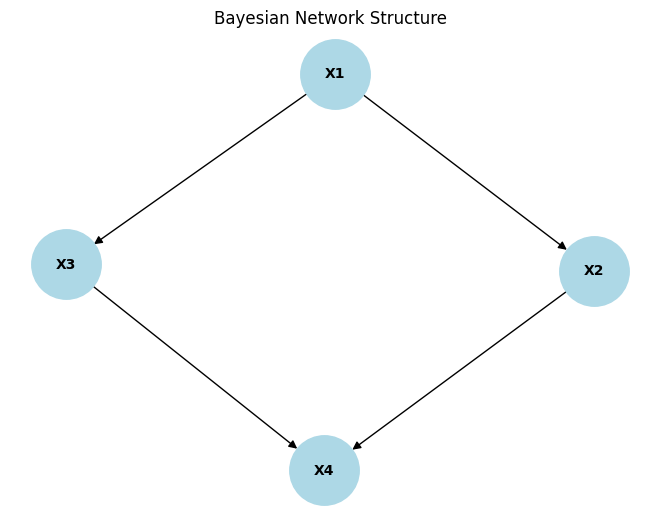

+-------+-----------+
| X4    |   phi(X4) |
+=======+===========+
| X4(0) |    0.4500 |
+-------+-----------+
| X4(1) |    0.5500 |
+-------+-----------+


In [90]:
#  (UAIML: Slides 31&32)
model = BayesianNetwork([('X1', 'X2'), ('X1', 'X3'), ('X2', 'X4'), ('X3', 'X4')])

cpd_X1 = TabularCPD(variable='X1', 
                    variable_card=2, 
                    values=[[0.6], [0.4]])
cpd_X2 = TabularCPD(variable='X2', 
                    variable_card=2, 
                    values=[[0.7, 0.2], [0.3, 0.8]], 
                    evidence=['X1'], 
                    evidence_card=[2])
cpd_X3 = TabularCPD(variable='X3', 
                    variable_card=2, 
                    values=[[0.8, 0.5], [0.2, 0.5]], 
                    evidence=['X1'], 
                    evidence_card=[2])
cpd_X4 = TabularCPD(variable='X4', 
                    variable_card=2, 
                    values=[[0.9, 0.4, 0.7, 0.1], [0.1, 0.6, 0.3, 0.9]], 
                    evidence=['X2', 'X3'], 
                    evidence_card=[2, 2])

model.add_cpds(cpd_X1, cpd_X2, cpd_X3, cpd_X4)

assert model.check_model()

G = nx.DiGraph()
G.add_nodes_from(['X1', 'X2', 'X3', 'X4'])
G.add_edges_from([('X1', 'X2'), ('X1', 'X3'), ('X2', 'X4'), ('X3', 'X4')])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=12)
plt.title("Bayesian Network Structure")
plt.show()

inference = VariableElimination(model)
result = inference.query(variables=['X4'], evidence={'X1': 1})

print(result)